### 1)Extraction des données 

In [14]:
import os
from os import listdir, path
import tarfile
import random
import numpy as np
import keras
from keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#attention au path bien avoir une hierarchie : data -> Dossier suivant dans data : data_test.tar.gz ,data_train.tar.gz, data_train.csv 
if not path.exists('data/data_test/'):
    print('Extracting test image files...')
    tar = tarfile.open("./data/data_test.tar.gz", "r:gz")
    tar.extractall('data/')
if not path.exists('data/data_train/'):
    print('Extracting train image files...')
    tar = tarfile.open("./data/data_train.tar.gz", "r:gz")
    tar.extractall('data/')

### Display utility functions

In [15]:
def show(image):
    plt.imshow(np.squeeze(image.astype("uint8")), cmap="gray")
    plt.title("image shape: "+ str(image.shape), fontsize=14)
    plt.axis('off');
    
def show_multiple(images, figsize):
    fig, ax = plt.subplots(ncols=len(images), figsize=figsize)
    for col, image in zip(ax, images):
        col.imshow(np.squeeze(image.astype("uint8")), cmap="gray")
        col.set_title("image shape: "+ str(image.shape), fontsize=14)
    plt.tight_layout()
    plt.axis('off');

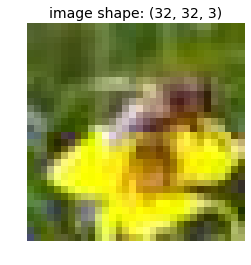

In [30]:
sample_image = imread("./data/data_train/10.jpg")
show(sample_image)

### Importer les Images (Train and Test) et les trier afin qu'elles soient en adéquation avec le fichier CSV

In [4]:
import pandas as pd
import os

def load_data(data_path):
    csv_path = os.path.join(data_path, "labels_train.csv")
    return pd.read_csv(csv_path) # note the returned variable

In [5]:
GLOBAL_DATA_PATH = "./data"
data = load_data(GLOBAL_DATA_PATH) #Pemet de charger les données du CSV

In [ ]:
import shutil, os

def split_img_in_subfolders(data) :
    for i in range(data.shape[0]) : 
        animal_folder_path = os.path.join('./','data', 'data_train', data['Category'][i])
        
        # Create folder if doesn't exist 
        if not path.exists(animal_folder_path):
            os.mkdir(animal_folder_path)
            
        # Copy the img in the associated folder    
        shutil.copy(os.path.join('./', 'data', 'data_train', str(data['Id'][i])) +'.jpg', os.path.join(animal_folder_path , str(data['Id'][i]) +'.jpg'))

In [13]:
split_img_in_subfolders(data)

In [6]:
def get_classes() :
    classes = []
    for animal in data['Category'] :
        if (animal not in classes) : 
            classes.append(animal)
        
    return classes

In [12]:
def get_splitted_data_with_size(image_size, sample_size, test_ratio, classes, seed):
    X, Y = [], []
    for label, animal in enumerate(classes):
        files = listdir(path.join('./data/data_train', animal))
        random.shuffle(files)
        files = files[:(sample_size // len(classes))]
        for file in files:
            img = load_img(path.join('./data/data_train', animal, file), 
                           target_size=image_size)
            X.append(img_to_array(img))
            Y.append(label)
    return train_test_split(np.asarray(X), np.asarray(Y), test_size=test_ratio, random_state=seed)

In [16]:
image_size = (224, 224, 3)
sample_size = 400
classes = get_classes()

X_tr, X_val, y_tr, y_val = get_splitted_data_with_size(
    image_size=image_size, sample_size=sample_size, test_ratio=0.25, classes=classes, seed=42
)

In [17]:
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((292, 224, 224, 3), (98, 224, 224, 3), (292,), (98,))

rabbit


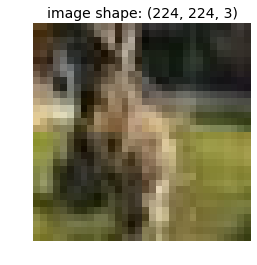

In [18]:
show(X_tr[1])
print(classes[y_tr[1]])

### MODEL : VIA RESNET 50 

In [19]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for ax, metric, name in zip(axs, ['acc', 'loss'], ['Accuracy', 'Loss']):
        ax.plot(
            range(1, len(model_history.history[metric]) + 1), 
            model_history.history[metric]
        )
        ax.plot(
            range(1, len(model_history.history['val_' + metric]) + 1), 
            model_history.history['val_' + metric]
        )
        ax.set_title('Model ' + name)
        ax.set_ylabel(name)
        ax.set_xlabel('Epoch')
        ax.legend(['train', 'val'], loc='best')
    plt.show()

In [20]:
import numpy as np
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model
from keras.preprocessing import image
from skimage.transform import resize
from skimage.io import imread

In [32]:
 #Basic Implementation of resnet model
model_ResNet50 = ResNet50(include_top=True, weights='imagenet')
#model_ResNet50.summary()

In [33]:
model_ResNet50.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
preds = model_ResNet50.predict(img_resized)
decode_predictions(preds, top=5)

In [38]:
#Print prediction of the unique image 
x = image.img_to_array(img_resized)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model_ResNet50.predict(x)
        
decoded_predictions = decode_predictions(preds)

if decoded_predictions:
    for _, name, score in decoded_predictions[0]:
        print(name, score)

dugong 0.44612902
fox_squirrel 0.16203322
grey_whale 0.14001317
Arctic_fox 0.08744889
ice_bear 0.038717896


In [19]:
model_ResNet50.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

batch_size = 128
num_epochs = 20

model = Sequential()

model.add(Dropout(0.8))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
    
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# The fit function allows you to fit the compiled model to some training data
if model:
    model_history = model.fit(
        x=X_tr, 
        y=y_tr, 
        batch_size=20, 
        epochs=20,
        verbose=1,
        validation_data=(X_val, y_val))
    
    print('Training complete')
else:
    model_history = None

ValueError: Error when checking target: expected dense_8 to have 4 dimensions, but got array with shape (146, 1)

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam

"""
Return a compiled Keras model
"""
def design_model():
    activation1 = 'relu'
    activation2 = 'sigmoid'
    kernel_height = 4
    kernel_width = 4
    output_filter = 32
    output_filter2 = 16
    model = Sequential()
    
    # TODO: 1st Convolution Layer
    model.add(Conv2D(output_filter2, (kernel_height, kernel_width), padding='SAME', input_shape=(image_size[0], image_size[1], image_size[2]))) 
    model.add(Activation(activation1)) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    
    #2nd Convolution Layer
    model.add(Conv2D(output_filter2, (kernel_height, kernel_width)))
    model.add(Activation(activation1)) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(0.7))
    model.add(Dense(128, activation = activation1))
    model.add(Dense(1, activation = activation2))

    return model

In [22]:
conv_model = design_model()

In [ ]:
batch_size = 100
num_epochs = 20  # The number of epochs (full passes through the data) to train for

conv_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# The fit function allows you to fit the compiled model to some training data
if conv_model:
    model_history = conv_model.fit(
        x=X_tr, 
        y=y_tr, 
        batch_size=batch_size, 
        epochs=num_epochs,
        verbose=1,
        validation_data=(X_val, y_val)
    )
    print('Training complete')
else:
    model_history = None

Train on 292 samples, validate on 98 samples
Epoch 1/20
292/292 [==============================] - 54s 184ms/step - loss: -79.0751 - acc: 0.0685 - val_loss: -84.7831 - val_acc: 0.0714
Epoch 2/20
292/292 [==============================] - 71s 242ms/step - loss: -96.2316 - acc: 0.0651 - val_loss: -86.5024 - val_acc: 0.0714
Epoch 3/20
100/292 [=========>....................] - ETA: 56s - loss: -96.2920 - acc: 0.0400

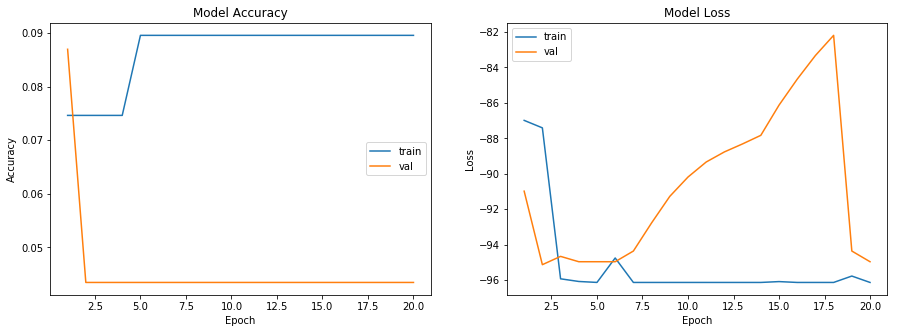

In [24]:
plot_model_history(model_history)